### Job Shop

In [1]:
import numpy as np
import cvxopt
from cvxopt import lapack, solvers, matrix, glpk
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
!pip install pulp
import sys
import random
from pulp import *

In [2]:
num_interviews = 27
# This is the name of the column that contains availability in the csv file.
name_col = "Applicant"
availability_col = "Interviews availability"
major_col = "Major"
# These are the dates and times from the csv file. Make sure they don't have a comma!
day1 = [
        "Monday April 1st - 6:00-7:00 pm", 
        "Monday April 1st - 7:00-8:00 pm", 
        "Monday April 1st - 8:00-9:00 pm"]
day2 = [
        "Tuesday April 2nd - 6:00-7:00 pm", 
        "Tuesday April 2nd - 7:00-8:00 pm", 
        "Tuesday April 2nd - 8:00-9:00 pm"]
day3 = [
        "Wednesday April 3rd - 6:00-7:00 pm",
        "Wednesday April 3rd - 7:00-8:00 pm",
        "Wednesday April 3rd - 8:00-9:00 pm"]
days = [day1, day2, day3]

def printSchedule(schedule):
     '''This will print the schedule with the times and the names of each applicant.'''
     timeSlots = np.array(days).flatten()
     for slot in range(len(schedule[0])):
         interviewees = np.where(schedule[:, slot] == 1)[0]
         names = [apps.loc[i, name_col] for i in interviewees]
         print(timeSlots[slot], "-", names) 

apps_file = "Applications.csv"
data = pd.read_csv(apps_file)

In [3]:
apps = data.head(n=num_interviews)

initial_num_cols = apps.shape[1]
for day in days:
    for time in day:
        col = apps.shape[1]
        apps.insert(col, time, 0)

# Go through the applicants and extract times
for index, applicant in apps.iterrows():
    availability = applicant[availability_col].split(", ")
    for time in availability:
        apps.loc[index, time] = 1
A = apps.iloc[:, initial_num_cols:].to_numpy()

interview_num_cols = apps.shape[1]
for index, applicant in apps.iterrows():
    majors = applicant[major_col].split(", ")
    for major in majors:
        if major in apps.columns:
                apps.loc[index, major] = 1
        else:
                col = apps.shape[1]
                apps.insert(col, major, 0)
                apps.loc[index, major] = 1
M = np.nan_to_num(apps.iloc[:, interview_num_cols:].to_numpy())
M_dict = {}
for i in range(0, M.shape[1]):
    M_dict[i] = list(np.where(M.T[i] == 1)[0])

In [4]:
apps

,Applicant,Major,Interviews availability,Monday April 1st - 6:00-7:00 pm,Monday April 1st - 7:00-8:00 pm,Monday April 1st - 8:00-9:00 pm,Tuesday April 2nd - 6:00-7:00 pm,Tuesday April 2nd - 7:00-8:00 pm,Tuesday April 2nd - 8:00-9:00 pm,Wednesday April 3rd - 6:00-7:00 pm,Wednesday April 3rd - 7:00-8:00 pm,Wednesday April 3rd - 8:00-9:00 pm,Computer Science,Aerospace Engineering,Mechanical Engineering,Electrical & Computer Engineering,Electrical Engineering,Environmental Engineering,Chemical and Biological Engineering,Biomedical Engineering
0,1,Computer Science,"Tuesday April 2nd - 6:00-7:00 pm, Tuesday Apri...",0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0
1,2,Aerospace Engineering,"Monday April 1st - 8:00-9:00 pm, Tuesday April...",0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0
2,3,Aerospace Engineering,"Tuesday April 2nd - 6:00-7:00 pm, Tuesday Apri...",0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0
3,4,Aerospace Engineering,"Monday April 1st - 6:00-7:00 pm, Monday April ...",1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,5,Aerospace Engineering,"Wednesday April 3rd - 6:00-7:00 pm, Wednesday ...",0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0
5,6,Computer Science,"Monday April 1st - 6:00-7:00 pm, Monday April ...",1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0
6,7,Computer Science,"Monday April 1st - 6:00-7:00 pm, Monday April ...",1,1,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0
7,8,Aerospace Engineering,Wednesday April 3rd - 6:00-7:00 pm,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
8,9,"Mechanical Engineering, Computer Science","Monday April 1st - 6:00-7:00 pm, Tuesday April...",1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0
9,10,Computer Science,"Monday April 1st - 6:00-7:00 pm, Tuesday April...",1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0


In [5]:
PPT = 3 #People per timeslot
CATEGORIES_DICT = M_dict
SCHEDULE = A
HOURS = np.array([1,2,3,25,26,27,49,50,51])

In [6]:
CATEGORIES = len(CATEGORIES_DICT)
APPLICANTS = SCHEDULE.shape[0]
TIME_SLOTS = SCHEDULE.shape[1]
assert len(HOURS) == TIME_SLOTS

In [7]:
def arr(start, length, total_length):
    assert start >= 1
    assert length >= 1
    assert total_length >= start + length - 1
    first_half = np.concatenate((np.zeros(start-1), np.ones(length)), axis=0)
    return np.concatenate((first_half, np.zeros(total_length-start-length+1)), axis=0)

def arr_mid(start, length, total_length):
    assert start >= 1
    assert length >= 2
    assert total_length >= start+length -1
    middle = np.hstack([[-1.0], np.ones(length-2), [-1.0]])
    first_half = np.concatenate((np.zeros(start-1), middle), axis=0)
    return np.concatenate((first_half, np.zeros(total_length-start-length+1)), axis=0)

def arr_with_columns(column, rows, columns):
    one_row = arr(column,1,columns)
    return np.reshape(np.vstack([one_row for x in range(rows)]), (rows*columns,))

In [8]:
#max(1x+2x_2+3x_3+25x+26x+27x+49x+50x+51x) over number of p in categories - min(...) over number of p in categories
#max(...) + max(-x-2x2....)
#min t + t2 for each category, total 10
# 1x+2x... <= t
#29 variables
#nonzero
G_nonzero = np.vstack([
    -1.0*np.eye(TIME_SLOTS*APPLICANTS+2*CATEGORIES),
    np.eye(TIME_SLOTS*APPLICANTS+2*CATEGORIES)
])
h_nonzero = np.hstack([
    np.zeros(TIME_SLOTS*APPLICANTS), max(HOURS)*np.ones(2*CATEGORIES),
    np.ones(TIME_SLOTS*APPLICANTS), max(HOURS)*np.ones(2*CATEGORIES)
])
c = np.hstack([np.zeros(TIME_SLOTS*APPLICANTS), np.ones(2*CATEGORIES)])
#each applicant is scheduled once
G_timeslots = np.vstack([
np.vstack([
    np.hstack([
        np.zeros(TIME_SLOTS*x),
        -1.0*np.ones(TIME_SLOTS),
        np.zeros(APPLICANTS*TIME_SLOTS-(x+1)*TIME_SLOTS),
        np.zeros(2*CATEGORIES)
    ]) for x in range(0,APPLICANTS)
]),
np.vstack([
    np.hstack([
        np.zeros(TIME_SLOTS*x),
        np.ones(TIME_SLOTS),
        np.zeros(APPLICANTS*TIME_SLOTS-(x+1)*TIME_SLOTS),
        np.zeros(2*CATEGORIES)
    ]) for x in range(0,APPLICANTS)
])
])
h_timeslots = np.hstack([-1.0*np.ones(APPLICANTS), np.ones(APPLICANTS)])
#total of 3 scheduled per hour
G_ppt = np.hstack([
    np.vstack([
        arr_with_columns(x,APPLICANTS,TIME_SLOTS) for x in range(1,TIME_SLOTS+1)
    ]), 
    np.zeros((TIME_SLOTS,2*CATEGORIES))
])
h_ppt = np.ones(TIME_SLOTS)*PPT
A_schedule = np.vstack([
    np.hstack([
        np.zeros(TIME_SLOTS*x), 
        SCHEDULE[x], 
        np.zeros(TIME_SLOTS*(APPLICANTS-x-1)), 
        np.zeros(2*CATEGORIES)
    ]) for x in range(0,APPLICANTS)
])
b_schedule = np.ones(APPLICANTS)
#scheduling categories
G_add = np.vstack([G_timeslots, G_ppt])
h_add = np.hstack([h_timeslots, h_ppt])
for key in CATEGORIES_DICT:
    G_max = np.vstack([
        np.hstack([
            np.zeros(TIME_SLOTS*x), 
            HOURS, 
            np.zeros(APPLICANTS*TIME_SLOTS-(x+1)*TIME_SLOTS), 
            np.zeros(2*key),
            [-1], 
            np.zeros(2*CATEGORIES-1-2*key)
        ]) for x in CATEGORIES_DICT[key]
    ])
    G_min = np.vstack([
        np.hstack([
            np.zeros(TIME_SLOTS*x), 
            -1.0*HOURS, 
            np.zeros(APPLICANTS*TIME_SLOTS-(x+1)*TIME_SLOTS), 
            np.zeros(2*key+1), 
            [-1], 
            np.zeros(2*CATEGORIES-2-2*key)
        ]) for x in CATEGORIES_DICT[key]
    ])
    h_max = np.zeros(len(CATEGORIES_DICT[key]))
    h_min = np.zeros(len(CATEGORIES_DICT[key]))
    G_add = np.vstack([G_add, G_max, G_min])
    h_add = np.hstack([h_add, h_max, h_min])
#
final_G = np.vstack([G_nonzero, G_add])#, G_max_3, G_max2_3])
final_h = np.hstack([h_nonzero, h_add])#, h_max_3, h_max2_3])
final_c = c
final_A = A_schedule
final_b = b_schedule
print(final_G.shape, final_h.shape, final_c.shape, final_A.shape, final_b.shape)
final_G = cvxopt.matrix(final_G)
final_h = cvxopt.matrix(final_h)
final_c = cvxopt.matrix(final_c)
final_A = cvxopt.matrix(final_A)
final_b = cvxopt.matrix(final_b)
(status, x) = cvxopt.glpk.ilp(final_c, final_G, final_h, final_A, final_b, I=set(range(TIME_SLOTS*APPLICANTS+2*CATEGORIES)))

(637, 259) (637,) (259,) (27, 259) (27,)
GLPK Integer Optimizer 5.0
664 rows, 259 columns, 1909 non-zeros
259 integer variables, none of which are binary
Preprocessing...
25 hidden covering inequaliti(es) were detected
40 constraint coefficient(s) were reduced
136 rows, 241 columns, 1295 non-zeros
241 integer variables, 225 of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  5.100e+01  ratio =  5.100e+01
GM: min|aij| =  3.742e-01  max|aij| =  2.672e+00  ratio =  7.141e+00
EQ: min|aij| =  1.400e-01  max|aij| =  1.000e+00  ratio =  7.141e+00
2N: min|aij| =  6.250e-02  max|aij| =  1.562e+00  ratio =  2.500e+01
Constructing initial basis...
Size of triangular part is 136
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
136 rows, 241 columns, 1295 non-zeros
      0: obj =  -3.060000000e+02 inf =   8.600e+01 (40)
     69: obj =   1.125639056e+02 inf =   3.460e-15 (0)
*   107: obj =   9.252061641e+01 inf =   9.652e-14 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization beg

In [9]:
schedule = np.array(x)[:APPLICANTS*TIME_SLOTS].reshape(APPLICANTS,TIME_SLOTS)
objective = sum(np.array(x)[APPLICANTS*TIME_SLOTS:])[0]

print(f"Schedule:\n", schedule)
print(f"Objective: {objective}")

Schedule:
 [[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Objective: 120.0


In [10]:
values = pd.DataFrame(np.array(x)[APPLICANTS*TIME_SLOTS:].reshape(CATEGORIES, 2), columns=["Max", "Min"])
values.Min = -values.Min
print(M_dict)
values["Difference"] = values.Max - values.Min
values

{0: [0, 5, 6, 8, 9, 12, 14, 25, 26], 1: [1, 2, 3, 4, 7, 21], 2: [8, 10, 13, 15, 16, 23], 3: [11, 24], 4: [17], 5: [18], 6: [19], 7: [20, 22]}


,Max,Min,Difference
0,51.0,3.0,48.0
1,50.0,3.0,47.0
2,25.0,1.0,24.0
3,26.0,25.0,1.0
4,27.0,27.0,0.0
5,27.0,27.0,0.0
6,1.0,1.0,0.0
7,2.0,2.0,0.0


Major Scheduled: 
 [[1. 2. 6.]
 [1. 2. 3.]
 [4. 2. 0.]
 [0. 2. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [2. 0. 0.]]
Monday April 1st - 6:00-7:00 pm - [14, 20, 24]
Monday April 1st - 7:00-8:00 pm - [11, 21, 23]
Monday April 1st - 8:00-9:00 pm - [4, 16, 26]
Tuesday April 2nd - 6:00-7:00 pm - [9, 12, 17]
Tuesday April 2nd - 7:00-8:00 pm - [1, 3, 25]
Tuesday April 2nd - 8:00-9:00 pm - [2, 18, 19]
Wednesday April 3rd - 6:00-7:00 pm - [8, 10, 13]
Wednesday April 3rd - 7:00-8:00 pm - [5, 7, 22]
Wednesday April 3rd - 8:00-9:00 pm - [6, 15, 27]


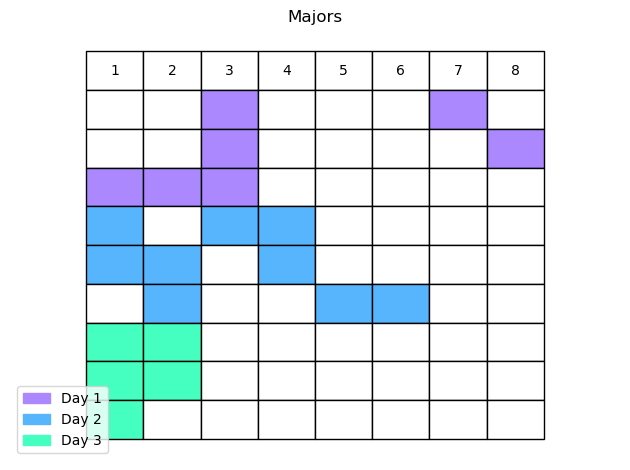

In [11]:
def plot_schedule(schedule, categories_dict=CATEGORIES_DICT):
    combined_schedule = np.empty(schedule.shape[1])
    for key in categories_dict:
        arr = categories_dict[key]
        temp = schedule[arr[0]]
        for element in arr:
            temp = np.logical_or(np.array(temp), np.array(schedule[element]))
            temp = np.where(temp, 1, 0)
        combined_schedule = np.vstack([combined_schedule, temp])
    combined_schedule = combined_schedule[1:].T
    colors = np.where(combined_schedule == 1, "#ac88ff", "w")
    colors_2 = np.where(combined_schedule == 1, "#56b5fd", "w")
    colors_3 = np.where(combined_schedule == 1, "#44ffc0", "w")
    final_colors = np.vstack([colors[:3], colors_2[3:6], colors_3[6:]])
    ax = plt.gca()
    ax.axis('off')
    ax.set_title("Majors")
    patch_1 = mpatches.Patch(color='#ac88ff', label='Day 1')
    patch_2 = mpatches.Patch(color='#56b5fd', label='Day 2')
    patch_3 = mpatches.Patch(color='#44ffc0', label='Day 3')
    ax.legend(handles=[patch_1, patch_2, patch_3], loc="lower left")
    table = plt.table(cellColours=final_colors, colLabels=range(1,combined_schedule.shape[1]+1), loc="center")
    table.scale(0.75,2)
    plt.tight_layout()
# Get the variables of if a major is scheduled on a day
majorScheduled = np.zeros((len(M[0]), len(days)))
combined_schedule = np.empty(schedule.shape[1])
for key in CATEGORIES_DICT:
    arr = CATEGORIES_DICT[key]
    temp = np.zeros(len(schedule[arr[0]]))
    for element in arr:
        temp += np.array(schedule[element])
    combined_schedule = np.vstack([combined_schedule, temp])
combined_schedule = combined_schedule[1:]
for m in range(len(M[0])):
        for i in range(len(days)):
            majorScheduled[m,i] = sum(combined_schedule[m][3*i:3*i+3])
print("Major Scheduled: \n", majorScheduled)
printSchedule(schedule)
plot_schedule(schedule)

### Max

In [12]:
############################################ ILP

model = LpProblem("Scheduling_Problem", LpMaximize)

# Variables
x = LpVariable.dicts("Interview", [(i,j) for i in range(len(A)) for j in range(len(A[0]))], cat='Binary')
majorDay = LpVariable.dicts("MajorOnDay", [(i,j) for i in range(len(M[0])) for j in range(len(days))], cat='Integer')
maxCountIndicator = LpVariable.dicts("MaxCountIndicator", [(i,j) for i in range(len(M[0])) for j in range(len(days))], cat='Binary')
maxMajorCount = LpVariable.dicts("MaxMajorCount", [(1,m) for m in range(len(M[0]))], cat='Integer')
bigM = 99999

# Objective Function
model += lpSum(maxMajorCount[1,m] for m in range(len(M[0])))

# Constraints
# Make sure that everyone is scheduled
model += lpSum(x[i,j]*A[i,j] for j in range(len(A[0])) for i in range(len(A))) == num_interviews
for i in range(len(A)): # Interveiwee can only be scheduled once
        model += lpSum([x[i,j] for j in range(len(A[0]))]) <= 1
for j in range(len(A[0])): # 3 interviewees can be scheduled per hour
        model += lpSum([x[i,j] for i in range(len(A))]) <= 3

for major in range(len(M[0])): # For summing the number of applicants for a major scheduled on a day.
      day_index = 0
      for day in range(len(days)):
            dayRange = range(day_index, day_index+len(days[day]))
            model += lpSum(x[i,j]*M[i,major] for j in dayRange for i in range(len(A))) == majorDay[major, day]
            day_index += len(days[day])

for major in range(len(M[0])): # Max(the sum of the number of applicants for a major on a day)
      model += lpSum(maxCountIndicator[major, d] for d in range(len(days))) == len(days)-1
      for day in range(len(days)):
            model += maxMajorCount[1, major] <= majorDay[major, day] + bigM*maxCountIndicator[major, day]
# Solve the problem
model.solve()

###############################################################

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/883040fdd90744ae90a9ba7959340b25-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/883040fdd90744ae90a9ba7959340b25-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 98 COLUMNS
At line 1665 RHS
At line 1759 BOUNDS
At line 2059 ENDATA
Problem MODEL has 93 rows, 299 columns and 960 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 533337 - 0.00 seconds
Cgl0008I 27 inequality constraints converted to equality constraints
Cgl0003I 0 fixed, 8 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 69 rows, 302 columns (302 integer (294 of which binary)) and 939 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 29 integers unsatisfied sum -

1

Status: Optimal
Major Scheduled: 
 [[2. 1. 6.]
 [1. 3. 2.]
 [5. 1. 0.]
 [0. 2. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [2. 0. 0.]]
Monday April 1st - 6:00-7:00 pm - [9, 14, 21]
Monday April 1st - 7:00-8:00 pm - [4, 23, 24]
Monday April 1st - 8:00-9:00 pm - [11, 16, 26]
Tuesday April 2nd - 6:00-7:00 pm - [2, 12, 22]
Tuesday April 2nd - 7:00-8:00 pm - [3, 19, 25]
Tuesday April 2nd - 8:00-9:00 pm - [1, 17, 18]
Wednesday April 3rd - 6:00-7:00 pm - [8, 10, 13]
Wednesday April 3rd - 7:00-8:00 pm - [5, 7, 15]
Wednesday April 3rd - 8:00-9:00 pm - [6, 20, 27]


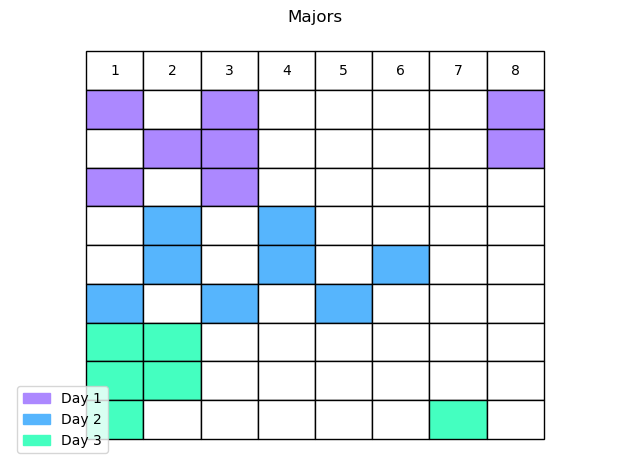

In [13]:
# Print the results
print("Status:", LpStatus[model.status])
schedule = np.zeros((len(A), len(A[0])))
for i in range(len(A)): # Get the schedule
     for j in range(len(A[0])):
          if (x[i,j].varValue == 1): schedule[i, j] = 1
#print("Schedule: \n", schedule) 
#print("Availability: \n", A)  

# Get the variables of if a major is scheduled on a day
majorScheduled = np.zeros((len(M[0]), len(days)))
for m in range(len(M[0])):
        for i in range(len(days)):
            if (majorDay[m,i].varValue > 0): majorScheduled[m,i] = majorDay[m,i].varValue
#print("Major: \n", M)
print("Major Scheduled: \n", majorScheduled)

maxCount = np.zeros((len(M[0])))
for m in range(len(M[0])):
      if (maxMajorCount[1,m].varValue > 0): maxCount[m] = maxMajorCount[1,m].varValue
#print("MaxCounts: \n", maxCount)

#print("Optimized value:", value(model.objective))

printSchedule(schedule)
plot_schedule(schedule)

### Min

In [14]:
################################################### ILP

model = LpProblem("Scheduling_Problem", LpMinimize)

# Variables
x = LpVariable.dicts("Interview", [(i,j) for i in range(len(A)) for j in range(len(A[0]))], cat='Binary')
majorDay = LpVariable.dicts("MajorOnDay", [(m,d) for m in range(len(M[0])) for d in range(len(days))], cat='Integer')
majorDayIndicator = LpVariable.dicts("MaxCountIndicator", [(m,d) for m in range(len(M[0])) for d in range(len(days))], cat='Binary')
bigM = 99999

# Objective Function
model += lpSum(majorDayIndicator[m, d] for m in range(len(M[0])) for d in range(len(days)))

# Constraints
# Make sure that everyone is scheduled
model += lpSum(x[i,j]*A[i,j] for j in range(len(A[0])) for i in range(len(A))) == num_interviews

for i in range(len(A)): # Interveiwee can only be scheduled once
        model += lpSum([x[i,j] for j in range(len(A[0]))]) <= 1
for j in range(len(A[0])): # 3 interviewees can be scheduled per hour
        model += lpSum([x[i,j] for i in range(len(A))]) <= 3

for major in range(len(M[0])): # For summing the number of applicants for a major scheduled on a day.
      day_index = 0
      for day in range(len(days)):
            dayRange = range(day_index, day_index+len(days[day]))
            model += lpSum(x[i,j]*M[i,major] for j in dayRange for i in range(len(A))) == majorDay[major, day]
            day_index += len(days[day])

for major in range(len(M[0])): # Indicator var if applicants of specific major scheduled on that day.
      for day in range(len(days)):
            model += majorDay[major, day] <= bigM*majorDayIndicator[major, day]

# Solve the problem
model.solve()

#######################################################



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/bbd5fa321f1e418ca6c062f4c4baac3b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/bbd5fa321f1e418ca6c062f4c4baac3b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 90 COLUMNS
At line 1609 RHS
At line 1695 BOUNDS
At line 1987 ENDATA
Problem MODEL has 85 rows, 291 columns and 912 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.000280003 - 0.00 seconds
Cgl0008I 27 inequality constraints converted to equality constraints
Cgl0003I 0 fixed, 0 tightened bounds, 14 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 9 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 10 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened 

1

Status: Optimal
Major Scheduled: 
 [[4. 1. 4.]
 [2. 2. 2.]
 [4. 2. 0.]
 [0. 2. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 2.]]
Monday April 1st - 6:00-7:00 pm - [9, 15, 24]
Monday April 1st - 7:00-8:00 pm - [4, 11, 13]
Monday April 1st - 8:00-9:00 pm - [2, 16, 26]
Tuesday April 2nd - 6:00-7:00 pm - [1, 12, 17]
Tuesday April 2nd - 7:00-8:00 pm - [3, 14, 18]
Tuesday April 2nd - 8:00-9:00 pm - [19, 22, 25]
Wednesday April 3rd - 6:00-7:00 pm - [7, 8, 10]
Wednesday April 3rd - 7:00-8:00 pm - [5, 6, 21]
Wednesday April 3rd - 8:00-9:00 pm - [20, 23, 27]


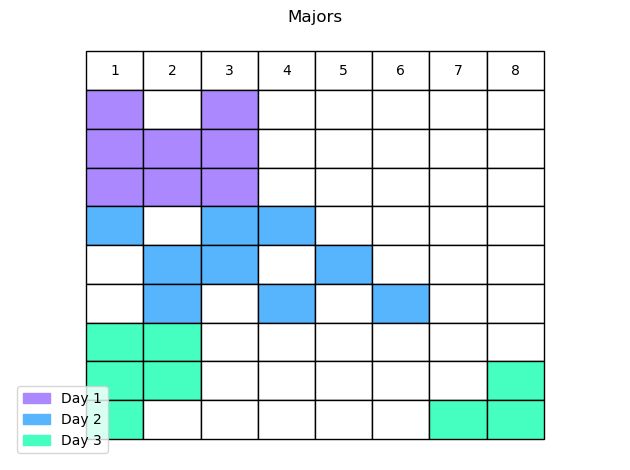

In [15]:
# Print the results
print("Status:", LpStatus[model.status])
schedule = np.zeros((len(A), len(A[0])))
for i in range(len(A)): # Get the schedule
     for j in range(len(A[0])):
          if (x[i,j].varValue == 1): schedule[i, j] = 1
#print("Schedule: \n", schedule) 
#print("Availability: \n", A)  

# Get the variables of if a major is scheduled on a day
majorScheduled = np.zeros((len(M[0]), len(days)))
majorIndicator = np.zeros((len(M[0]), len(days)))
for m in range(len(M[0])):
        for i in range(len(days)):
            if (majorDay[m,i].varValue > 0): majorScheduled[m,i] = majorDay[m,i].varValue
            if (majorDayIndicator[m,i].varValue > 0): majorIndicator[m,i] = majorDayIndicator[m,i].varValue
#print("Major: \n", M)
print("Major Scheduled: \n", majorScheduled)
#print("Major indicator: \n", majorIndicator)

#print("Optimized value:", value(model.objective))

printSchedule(schedule)
plot_schedule(schedule)

### Max-Min

In [16]:
############################################ ILP

model = LpProblem("Scheduling_Problem", LpMaximize)

# Variables
x = LpVariable.dicts("Interview", [(i,j) for i in range(len(A)) for j in range(len(A[0]))], cat='Binary')
majorDay = LpVariable.dicts("MajorOnDay", [(i,j) for i in range(len(M[0])) for j in range(len(days))], cat='Integer')
maxCountIndicator = LpVariable.dicts("MaxCountIndicator", [(i,j) for i in range(len(M[0])) for j in range(len(days))], cat='Binary')
maxMajorCount = LpVariable.dicts("MaxMajorCount", [(1,m) for m in range(len(M[0]))], cat='Integer')
majorDayIndicator = LpVariable.dicts("MajorCountIndicator", [(m,d) for m in range(len(M[0])) for d in range(len(days))], cat='Binary')
bigM = 99999

# Objective Function
model += lpSum(maxMajorCount[1,m] for m in range(len(M[0]))) - lpSum(majorDayIndicator[m, d] for m in range(len(M[0])) for d in range(len(days)))

# Constraints
# Make sure that everyone is scheduled
model += lpSum(x[i,j]*A[i,j] for j in range(len(A[0])) for i in range(len(A))) == num_interviews

for i in range(len(A)): # Interveiwee can only be scheduled once
        model += lpSum([x[i,j] for j in range(len(A[0]))]) <= 1
for j in range(len(A[0])): # 3 interviewees can be scheduled per hour
        model += lpSum([x[i,j] for i in range(len(A))]) <= 3

for major in range(len(M[0])): # For summing the number of applicants for a major scheduled on a day.
      day_index = 0
      for day in range(len(days)):
            dayRange = range(day_index, day_index+len(days[day]))
            model += lpSum(x[i,j]*M[i,major] for j in dayRange for i in range(len(A))) == majorDay[major, day]
            model += majorDay[major, day] <= majorDayIndicator[major, day] * bigM
            # Max(the sum of the number of applicants for a major on a day)

            day_index += len(days[day])

for major in range(len(M[0])): # Max(the sum of the number of applicants for a major on a day)
      model += lpSum(maxCountIndicator[major, d] for d in range(len(days))) == len(days)-1
      for day in range(len(days)):
            model += maxMajorCount[1, major] <= majorDay[major, day] + bigM*maxCountIndicator[major, day]
# Solve the problem
model.solve()

###############################################################

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/60fe910608e8418793a1c6964af81473-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/60fe910608e8418793a1c6964af81473-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 122 COLUMNS
At line 1809 RHS
At line 1927 BOUNDS
At line 2251 ENDATA
Problem MODEL has 117 rows, 323 columns and 1008 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 533337 - 0.00 seconds
Cgl0003I 0 fixed, 8 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 12 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 11 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 str

1

Major Scheduled: 
 [[2. 1. 6.]
 [1. 2. 3.]
 [5. 1. 0.]
 [0. 2. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [2. 0. 0.]]
Monday April 1st - 6:00-7:00 pm - [9, 14, 24]
Monday April 1st - 7:00-8:00 pm - [4, 23, 26]
Monday April 1st - 8:00-9:00 pm - [11, 16, 21]
Tuesday April 2nd - 6:00-7:00 pm - [1, 2, 12]
Tuesday April 2nd - 7:00-8:00 pm - [3, 17, 25]
Tuesday April 2nd - 8:00-9:00 pm - [18, 19, 20]
Wednesday April 3rd - 6:00-7:00 pm - [8, 10, 13]
Wednesday April 3rd - 7:00-8:00 pm - [7, 15, 22]
Wednesday April 3rd - 8:00-9:00 pm - [5, 6, 27]


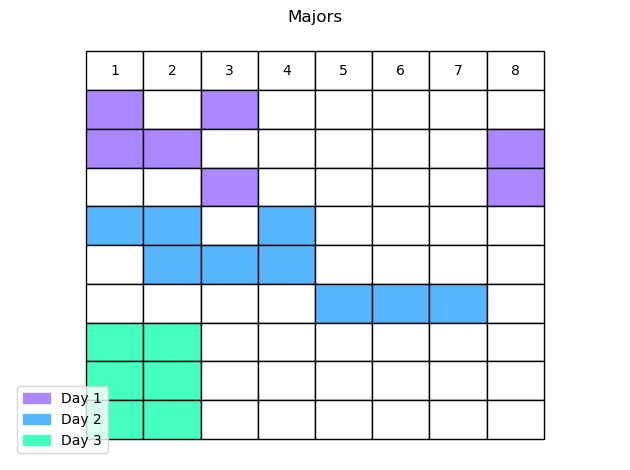

In [17]:
# Print the results
#print("Status:", LpStatus[model.status])
schedule = np.zeros((len(A), len(A[0])))
for i in range(len(A)): # Get the schedule
     for j in range(len(A[0])):
          if (x[i,j].varValue == 1): schedule[i, j] = 1
#print("Schedule: \n", schedule) 
#print("Availability: \n", A)  

# Get the variables of if a major is scheduled on a day
majorScheduled = np.zeros((len(M[0]), len(days)))
majorIndicator = np.zeros((len(M[0]), len(days)))
for m in range(len(M[0])):
        for i in range(len(days)):
            if (majorDay[m,i].varValue > 0): majorScheduled[m,i] = majorDay[m,i].varValue
            if (majorDayIndicator[m,i].varValue > 0): majorIndicator[m,i] = majorDayIndicator[m,i].varValue
#print("Major: \n", M)
print("Major Scheduled: \n", majorScheduled)
#print("Major indicator: \n", majorIndicator)


maxCount = np.zeros((len(M[0])))
for m in range(len(M[0])):
      if (maxMajorCount[1,m].varValue > 0): maxCount[m] = maxMajorCount[1,m].varValue
#print("MaxCounts: \n", maxCount)

#print("Optimized value:", value(model.objective))

printSchedule(schedule)
plot_schedule(schedule)

In [18]:
max_schedule = np.array([
 [0, 0, 0, 0, 1, 0, 0, 0, 0], #1 CS
 [0, 0, 0, 1, 0, 0, 0, 0, 0], #2 Aero
 [0, 0, 0, 0, 1, 0, 0, 0, 0], #3
 [0, 1, 0, 0, 0, 0, 0, 0, 0], #4
 [0, 0, 0, 0, 0, 0, 0, 0, 1], #5 
 [0, 0, 0, 0, 0, 0, 0, 1, 0], #6 CS
 [0, 0, 0, 0, 0, 0, 0, 1, 0], #7
 [0, 0, 0, 0, 0, 0, 1, 0, 0], #8 Aero
 [1, 0, 0, 0, 0, 0, 0, 0, 0], #9 ME
 [0, 0, 0, 0, 0, 0, 1, 0, 0], #10 CS
 [0, 1, 0, 0, 0, 0, 0, 0, 0], #11 ME
 [0, 0, 0, 1, 0, 0, 0, 0, 0], #12 E&CE
 [0, 0, 0, 0, 0, 0, 1, 0, 0], #13 CS
 [1, 0, 0, 0, 0, 0, 0, 0, 0], #14 ME
 [0, 0, 0, 0, 0, 0, 0, 0, 1], #15 CS
 [0, 0, 1, 0, 0, 0, 0, 0, 0], #16 ME
 [0, 0, 0, 0, 0, 1, 0, 0, 0], #17 
 [0, 0, 0, 1, 0, 0, 0, 0, 0], #18 EE
 [0, 0, 0, 0, 0, 1, 0, 0, 0], #19 Envi
 [0, 0, 0, 0, 0, 0, 0, 1, 0], #20 ChemBio
 [0, 1, 0, 0, 0, 0, 0, 0, 0], #21 Biomed
 [0, 0, 0, 0, 0, 1, 0, 0, 0], #22 Aero
 [0, 0, 1, 0, 0, 0, 0, 0, 0], #23 Biomed
 [1, 0, 0, 0, 0, 0, 0, 0, 0], #24 ME
 [0, 0, 0, 0, 1, 0, 0, 0, 0], #25 E&CE
 [0, 0, 1, 0, 0, 0, 0, 0, 0], #26 CS
 [0, 0, 0, 0, 0, 0, 0, 0, 1]]) #27 CS
min_schedule = np.array([
 [0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1]]
)
max_min_schedule = np.array([
 [0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1]]
)